# Fall Problem Session 10
## Classifying Pumpkin Seeds IV

In this notebook you continue to work with the pumpkin seed data from <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021). By the end of the notebook you will select a final model for this data and check its performance on the test set.

The problems in this notebook will cover the content covered in some of our `Classification`, `Dimension Reduction` and our `Ensemble Learning` notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load and prepare the data and refresh your memory

Run the code below in order to:

- Load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `Data` folder,
- Create a column `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik` and
- Make a train test split setting $10\%$ of the data aside as a test set.

If you need to refresh your memory on these data and the problem, you may want to look at a small subset of the data, look back on `Fall Problem Session 7`, `Fall Problem Session 8` and `Fall Problem Session 9` and/or browse Figure 5 and Table 1 of this paper, <a href="pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>

In [2]:
seeds = pd.read_excel("../Data/Pumpkin_Seeds_Dataset.xlsx")

seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
seeds_train, seeds_test = train_test_split(seeds.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y.values)

features = seeds_train.columns[:-2]

#### 2. An AdaBoost classifier


##### a.

Import the adaptive boosting classifier model and decision tree models from `sklearn`

##### Sample Solution

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

##### b.

Using either a `for` loop or `GridSearchCV` determine the optimal value for `n_estimators` for an `AdaBoostClassifier` using a `DecisionTreeClassifier` with `max_depth=2` as its base estimator. Set the `learning_rate=1` in the `AdaBoostClassifier`. 

Plot the average cross-validation accuracy against the value of `n_estimators`.

##### Sample Solution

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
n_estimators = range(1,26)

grid_cv = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                             learning_rate=1),
                          param_grid = {'n_estimators':n_estimators}, 
                          scoring = 'accuracy', 
                          cv = 10)

grid_cv.fit(seeds_train[features], seeds_train.y)

accs = np.zeros((10,len(n_estimators)))

for i in range(10):
    accs[i,:] = grid_cv.cv_results_['split' + str(i) + '_test_score']

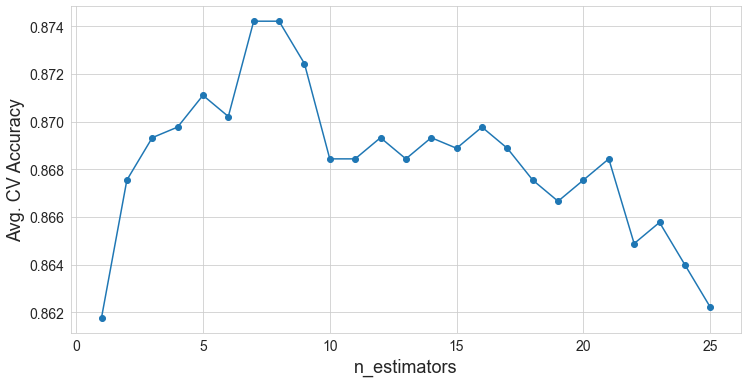

In [8]:
plt.figure(figsize=(12,6))

plt.plot(n_estimators,
            np.mean(accs, axis=0),
         '-o')

plt.xlabel("n_estimators", fontsize=18)
plt.ylabel("Avg. CV Accuracy", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

##### c.

How many decision trees do you choose for your adaptive boosting classifier?

##### Sample Solution

8

#### 3. A voting classifier

In this problem you will explore making a voting classifier for these data.

##### a.

Recall that a voting classifier is a classification model where the prediction for a particular observation is an average of the predictions from a group of classifiers.

As a first step to building a voting classifier review the best models you have built through `Fall Problem Session 7` to `Fall Problem Session 9`:

- A logistic regression model regressing `y` on a single feature,
- A $k$ nearest neighbors model using PCA processed features as input,
- A support vector machine model,
- A quadratic discriminant analysis model,
- A random forest model and, in this notebook,
- An adaptive boosting model.

##### b. 

We should only expect a voting classifier to perform better than its constituent models when there is not a lot of overlap in the observations that each model incorrectly classifies. For example, if most of your models are incorrect about a particular observation, then the voter model will also be incorrect for that observation.

As an initial investigation for the voter model:

- Make a validation set of size 100 from the training data,
- Fill in the missing pieces of code to fit all of the models you have considered up to this point on the training set from the validation split you just made,
- Get predictions for all of these models on the validation set and
- Then run the `plt.imshow` code chunk to show where these models were incorrect on the validation set.

##### Sample Solution

In [9]:
## First import everything we'll need
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
## Make the validation split
seeds_tt, seeds_val = train_test_split(seeds_train,
                              shuffle=True,
                              random_state=3932,
                              test_size=100,
                              stratify = seeds_train.y)

In [11]:
##### make all the model objects ####

## Adaptive Boosting
## fill in the parameters you found above
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                             learning_rate=1,
                                              n_estimators=8)

## K nearest neighbors with PCA pre-processing
knn = Pipeline([('scale', StandardScaler()),
                   ('pca', PCA(3)),
                   ('knn', KNeighborsClassifier(38))])

## QDA
qda = Pipeline([('scale', StandardScaler()),
                    ('qda', QuadraticDiscriminantAnalysis())])

## Logistic Regression
log_reg = LogisticRegression()

## Support vector machine
svm = Pipeline([('scale', StandardScaler()),
                   ('svm', SVC(C = 30))])

## Random Forest
rf = RandomForestClassifier(max_depth=8, 
                            n_estimators=500)


##### Fit all of the models #####
ada_boost.fit(seeds_tt[features], seeds_tt.y)
knn.fit(seeds_tt[features], seeds_tt.y)
qda.fit(seeds_tt[features], seeds_tt.y)
log_reg.fit(seeds_tt['Aspect_Ration'].values.reshape(-1,1), seeds_tt.y)
svm.fit(seeds_tt[features], seeds_tt.y)
rf.fit(seeds_tt[features], seeds_tt.y)
  
    
##### Get predictions on the validation set #####
ada_pred = ada_boost.predict(seeds_val[features])
knn_pred = knn.predict(seeds_val[features])
qda_pred = qda.predict(seeds_val[features])
log_pred = log_reg.predict(seeds_val['Aspect_Ration'].values.reshape(-1,1))
svm_pred = svm.predict(seeds_val[features])
rf_pred = rf.predict(seeds_val[features])


##### This records what observations in the validation set
##### Each model got wrong
wrongs = np.zeros((6, len(seeds_val)))
wrongs[0,:] = ada_pred != seeds_val.y.values
wrongs[1,:] = knn_pred != seeds_val.y.values
wrongs[2,:] = qda_pred != seeds_val.y.values
wrongs[3,:] = log_pred != seeds_val.y.values
wrongs[4,:] = svm_pred != seeds_val.y.values
wrongs[5,:] = rf_pred != seeds_val.y.values

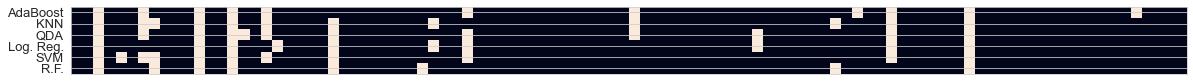

In [12]:
### This makes a heat map of where each model was incorrect
### A bright spot indicates the model was wrong for that observation
plt.figure(figsize=(20,20))
plt.imshow(wrongs)

plt.xticks([])
plt.yticks([0,1,2,3,4,5], 
              ["AdaBoost", "KNN", "QDA", "Log. Reg.", "SVM", "R.F."],
              fontsize=13)
plt.show()

##### c. 

Look at the heat map you just made. Each square in this map indicates whether a model (the rows) got a particular observation (the columns) incorrect. A bright square indicates a model was incorrect for that observation, a dark square indicates that it was correct.

Based on this investigatory heat map do you think that a voter model made up of these models would do better than any one model? Why or Why not?

##### Sample Solution

While it is possible that the voter model will outperform the best model, it does not seem to be the case for this validation set. Looking at the row corresponding to the random forest model there are only two instances in which the voter model would be correct while the random forest would be incorrect. There are at least four instances in which the random forest model would be correct but the voter model would be incorrect.


However, it is important to note that this is just looking at a single validation set, but not multiple validation sets, so we do not know if this would hold in general.

##### d. 

Make a voter model using all of the models considered in <i>b.</i> above. Train it on the training set from the validation split. Then compare the accuracies of all models on the validation set to the voter model's validation accuracy. The code has been started for you because the logistic regression model required particular preprocessing in order to be fed into the voter model.

##### Sample Solution

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer

In [14]:
def get_single_feature(df):
    return df['Aspect_Ration'].values.reshape(-1,1)

vote = VotingClassifier([('log_reg', Pipeline([('get_column', FunctionTransformer(get_single_feature)),
                                                 ('log_reg', LogisticRegression())])),
                            ('ada_boost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                             learning_rate=1,
                                              n_estimators=8)),
                            ('knn', Pipeline([('scale', StandardScaler()),
                                               ('pca', PCA(3)),
                                               ('knn', KNeighborsClassifier(38))])),
                            ('qda', Pipeline([('scale', StandardScaler()),
                                                ('qda', QuadraticDiscriminantAnalysis())])),
                            ('svm', Pipeline([('scale', StandardScaler()),
                                               ('svm', SVC(C = 30))])),
                            ('rf', RandomForestClassifier(max_depth=8, 
                                                            n_estimators=500))])


vote.fit(seeds_tt[features], seeds_tt.y)

vote_pred = vote.predict(seeds_val[features])

vote_acc = accuracy_score(seeds_val.y, vote_pred)
log_acc = accuracy_score(seeds_val.y, log_pred)
knn_acc = accuracy_score(seeds_val.y, knn_pred)
ada_acc = accuracy_score(seeds_val.y, ada_pred)
qda_acc = accuracy_score(seeds_val.y, qda_pred)
svm_acc = accuracy_score(seeds_val.y, svm_pred)
rf_acc = accuracy_score(seeds_val.y, rf_pred)


In [15]:
print("Logistic regression validataion set accuracy = ", np.round(log_acc*100, 2))
print("KNN validataion set accuracy = ", np.round(knn_acc*100, 2))
print("QDA validataion set accuracy = ", np.round(qda_acc*100, 2))
print("SVM validataion set accuracy = ", np.round(svm_acc*100, 2))
print("Random forest validataion set accuracy = ", np.round(rf_acc*100, 2))
print("Adaboost validataion set accuracy = ", np.round(ada_acc*100, 2))
print("=========================================")
print("Voter model validataion set accuracy = ", np.round(vote_acc*100, 2))


Logistic regression validataion set accuracy =  90.0
KNN validataion set accuracy =  88.0
QDA validataion set accuracy =  88.0
SVM validataion set accuracy =  89.0
Random forest validataion set accuracy =  92.0
Adaboost validataion set accuracy =  89.0
Voter model validataion set accuracy =  90.0


#### 4. Choosing a final model

##### a.

Fill in the missing code below to run each of the seven models you just considered through 10-fold cross-validation.

##### Sample Solution

In [16]:
from sklearn.model_selection import StratifiedKFold

In [17]:
n_splits = 10
kfold = StratifiedKFold(n_splits, 
                           shuffle=True,
                           random_state=2013)


cv_accs = np.zeros((n_splits, 7))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ### Making the model objects ###
    
    ## Adaptive Boosting
    ## fill in the parameters you found above
    ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                                 learning_rate=1,
                                                  n_estimators=8)

    ## K nearest neighbors with PCA pre-processing
    knn = Pipeline([('scale', StandardScaler()),
                       ('pca', PCA(3)),
                       ('knn', KNeighborsClassifier(38))])

    ## QDA
    qda = Pipeline([('scale', StandardScaler()),
                        ('qda', QuadraticDiscriminantAnalysis())])

    ## Logistic Regression
    log_reg = LogisticRegression()

    ## Support vector machine
    svm = Pipeline([('scale', StandardScaler()),
                       ('svm', SVC(C = 30))])

    ## Random Forest
    rf = RandomForestClassifier(max_depth=8, 
                                n_estimators=500)
    
    ## Vote
    vote = VotingClassifier([('log_reg', Pipeline([('get_column', FunctionTransformer(get_single_feature)),
                                                 ('log_reg', LogisticRegression())])),
                            ('ada_boost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                             learning_rate=1,
                                              n_estimators=8)),
                            ('knn', Pipeline([('scale', StandardScaler()),
                                               ('pca', PCA(3)),
                                               ('knn', KNeighborsClassifier(38))])),
                            ('qda', Pipeline([('scale', StandardScaler()),
                                                ('qda', QuadraticDiscriminantAnalysis())])),
                            ('svm', Pipeline([('scale', StandardScaler()),
                                               ('svm', SVC(C = 30))])),
                            ('rf', RandomForestClassifier(max_depth=8, 
                                                            n_estimators=500))])
    
    
    ### Fitting the models ###
    ada_boost.fit(seeds_tt[features], seeds_tt.y)
    knn.fit(seeds_tt[features], seeds_tt.y)
    qda.fit(seeds_tt[features], seeds_tt.y)
    log_reg.fit(seeds_tt['Aspect_Ration'].values.reshape(-1,1), seeds_tt.y)
    svm.fit(seeds_tt[features], seeds_tt.y)
    rf.fit(seeds_tt[features], seeds_tt.y)
    vote.fit(seeds_tt[features], seeds_tt.y)

    
    ### Getting predictions ###
    ada_pred = ada_boost.predict(seeds_ho[features])
    knn_pred = knn.predict(seeds_ho[features])
    qda_pred = qda.predict(seeds_ho[features])
    log_pred = log_reg.predict(seeds_ho['Aspect_Ration'].values.reshape(-1,1))
    svm_pred = svm.predict(seeds_ho[features])
    rf_pred = rf.predict(seeds_ho[features])
    vote_pred = vote.predict(seeds_ho[features])

    
    ### Recording Accuracies ###
    cv_accs[i, 0] = accuracy_score(seeds_ho.y, ada_pred)
    cv_accs[i,1] = accuracy_score(seeds_ho.y, knn_pred)
    cv_accs[i,2] = accuracy_score(seeds_ho.y, qda_pred)
    cv_accs[i,3] = accuracy_score(seeds_ho.y, log_pred)
    cv_accs[i,4] = accuracy_score(seeds_ho.y, svm_pred)
    cv_accs[i,5] = accuracy_score(seeds_ho.y, rf_pred)
    cv_accs[i,6] = accuracy_score(seeds_ho.y, vote_pred)

    i = i + 1

#### b. 

Which model had the best average cross-validation accuracy?

##### Sample Solution

In [18]:
np.mean(cv_accs, axis=0)

array([0.87777778, 0.88444444, 0.884     , 0.86755556, 0.88977778,
       0.892     , 0.89288889])

It looks like the random forest has a slight edge over the voter model.

##### c. 

Remember that it is often useful to compare your best model to a simple baseline. In this case the logistic regression model using a single feature is a good baseline we can use. How much does your best model improve upon this baseline? Is your model easier to interpret than the logistic regression model? Could you think of a situation in which we would go with the logistic regression model instead of the one with the best average cross-validation accuracy?

##### Sample Solution

The random forest model has an average cross-validation accuracy that is about three percentage points better than the simple logistic regression model, so not a massive improvement.

While the random forest model does allow us to see which features are most important to determining what kind of pumpkin seed we have, it is not as directly interpretable as the simpler logistic regression model. That model tells us how the odds of being a certain pumpkin seed as we change the `Aspect_Ration` variable.

One reason we may want to use the logistic regression model instead is if we want to be able to give a guess at the pumpkin seed type without running it through the final model. We could see what the `Aspect_Ration` is for that particular set of seeds and use that information along with our fitted logistic regression coefficients to make an informed guess.

##### d.

Train the model you chose on the entire training set. Then compute the accuracies on the training set and the test set. Does the model seem to be overfitting?

##### Sample Solution

In [19]:
rf = RandomForestClassifier(max_depth=8, 
                                n_estimators=500)

rf.fit(seeds_train[features],
          seeds_train.y)

train_pred = rf.predict(seeds_train[features])
test_pred = rf.predict(seeds_test[features])

train_acc = accuracy_score(seeds_train.y, train_pred)
test_acc = accuracy_score(seeds_test.y, test_pred)

print("Training Accuracy:", np.round(100*train_acc, 2))
print("Test Accuracy:", np.round(100*test_acc, 2))

Training Accuracy: 94.18
Test Accuracy: 86.0


The model probably does overfit a little bit.

#### 5. Considering other metrics

##### a.

In this classification problem we only considered accuracy, which was reasonable given the problem as well as the near $50\%-50\%$ split of the two pumpkin seed classes.

Describe a situation in which you would want to consider a metric other than accuracy.

##### Sample Solution

One such situation might be if one class of pumpkin seed was much more valuable than the other. We may care more about things like:
- limiting false positives to avoid upset customers or
- increasing true positives to increase our profits.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)